## Importing

In [11]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error as mse

import os

from time import sleep
from tqdm import tqdm


## Datasets Preparation 

In [12]:
def datasets_preparation (i):

     # Dataset and date    
     ds_name = ('/results2/SalishSea/nowcast-green.202111/' + i + '/SalishSea_1d_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]])+str(i[0:2]) + '_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]]) + str(i[0:2]) + '_grid_T.nc')

     ds_bio_name = ('/results2/SalishSea/nowcast-green.202111/' + i + '/SalishSea_1d_'  + '20' + str(i[5:7]) + str(dict_month[i[2:5]])+str(i[0:2]) + '_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]]) + str(i[0:2]) + '_biol_T.nc')

     ds = xr.open_dataset (ds_name)
     ds_bio = xr. open_dataset (ds_bio_name)

     temp_i1 = (ds.votemper.where(mask==1)[0,0:15] * ds.e3t.where(mask==1)
               [0,0:15]).sum('deptht', skipna = True, min_count = 15) / mesh.gdepw_0[0,15]
     temp_i2 = (ds.votemper.where(mask==1)[0,15:27] * ds.e3t.where(mask==1)
               [0,15:27]).sum('deptht', skipna = True, min_count = 12) / (mesh.gdepw_0[0,27] - mesh.gdepw_0[0,14])
     saline_i1 = (ds.vosaline.where(mask==1)[0,0:15] * ds.e3t.where(mask==1)
                    [0,0:15]).sum('deptht', skipna = True, min_count = 15) / mesh.gdepw_0[0,15]
     saline_i2 = (ds.vosaline.where(mask==1)[0,15:27] * ds.e3t.where(mask==1)
                    [0,15:27]).sum('deptht', skipna = True, min_count = 12) / (mesh.gdepw_0[0,27] - mesh.gdepw_0[0,14])

     diat_i = (ds_bio.diatoms.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
               [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]
     flag_i = (ds_bio.flagellates.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
               [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

     return (temp_i1, temp_i2, saline_i1, saline_i2, diat_i, flag_i)


## Dataset Presentation (Yesterday)

In [13]:
def datasets_preparation_y(i):

    # Dataset and date    
    ds_name = ('/results2/SalishSea/nowcast-green.202111/' + i + '/SalishSea_1d_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]])+str(i[0:2]) + '_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]]) + str(i[0:2]) + '_grid_T.nc')

    ds = xr.open_dataset (ds_name)

    temp_i1_y = (ds.votemper.where(mask==1)[0,0:15] * ds.e3t.where(mask==1)
    [0,0:15]).sum('deptht', skipna = True, min_count = 15) / mesh.gdepw_0[0,15]

    temp_i2_y = (ds.votemper.where(mask==1)[0,15:27] * ds.e3t.where(mask==1)
    [0,15:27]).sum('deptht', skipna = True, min_count = 12) / (mesh.gdepw_0[0,27] - mesh.gdepw_0[0,14])

    saline_i1_y = (ds.vosaline.where(mask==1)[0,0:15] * ds.e3t.where(mask==1)
    [0,0:15]).sum('deptht', skipna = True, min_count = 15) / mesh.gdepw_0[0,15]

    saline_i2_y = (ds.vosaline.where(mask==1)[0,15:27] * ds.e3t.where(mask==1)
    [0,15:27]).sum('deptht', skipna = True, min_count = 12) / (mesh.gdepw_0[0,27] - mesh.gdepw_0[0,14])

    return (temp_i1_y, temp_i2_y, saline_i1_y, saline_i2_y)


## Regressor

In [14]:
def regressor (inputs, targets, variable_name):
    
    inputs = inputs.transpose()
    
    # Regressor
    scale = preprocessing.StandardScaler()
    inputs2 = scale.fit_transform(inputs)
    X_train, X_test, y_train, y_test = train_test_split(inputs2, targets)

    extra_tree = ExtraTreeRegressor(criterion='poisson')
    regr = BaggingRegressor(extra_tree, n_estimators=10, max_features=8).fit(X_train, y_train)

    outputs_test = regr.predict(X_test)

    m = scatter_plot(y_test, outputs_test, variable_name + ' (Testing dataset)') 
    r = np.round(np.corrcoef(y_test, outputs_test)[0][1],3)
    rms = np.round(mse(y_test, outputs_test),4)
    

    return (r, rms, m, regr)

# Printing

In [15]:
def printing (targets, outputs, m):

    print ('The amount of data points is', outputs.size)
    print ('The slope of the best fitting line is ', np.round(m,3))
    print ('The correlation coefficient is:', np.round(np.corrcoef(targets, outputs)[0][1],3))
    print (' The mean square error is:', np.round(mse(targets,outputs),5))


## Scatter Plot

In [16]:
def scatter_plot(targets, outputs, variable_name):

    # compute slope m and intercept b
    m, b = np.polyfit(targets, outputs, deg=1)

    printing (targets, outputs, m)
    
    fig, ax = plt.subplots()

    plt.scatter(targets,outputs, alpha = 0.2, s = 10)
    plt.xlabel('targets')
    plt.ylabel('outputs')

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # plot fitted y = m*x + b
    plt.axline(xy1=(0, b), slope=m, color='r')

    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.plot(lims, lims,linestyle = '--',color = 'k')

    fig.suptitle(str(year) + ', ' + variable_name)

    plt.show()

    return (m)


## Plotting

In [17]:
def plotting (variable, name):

    plt.plot(years,variable, marker = '.', linestyle = '')
    plt.legend(['diatom','flagellate'])
    plt.xlabel('Years')
    plt.ylabel(name)
    plt.show()

## Regressor 2

In [18]:
def regressor2 (inputs, targets, variable_name):
    
    inputs = inputs.transpose()
    
    # Regressor
    scale = preprocessing.StandardScaler()
    inputs2 = scale.fit_transform(inputs)

    outputs_test = regr.predict(inputs2)

    m = scatter_plot(targets, outputs_test, variable_name + ' (Testing dataset)') 
    r = np.round(np.corrcoef(targets, outputs_test)[0][1],3)
    rms = np.round(mse(targets, outputs_test),4)

    return (r, rms, m)

## Training of 2011

Gathering days for year 2011


100%|██████████| 75/75 [04:14<00:00,  3.39s/it]


Done gathering, building the prediction model


The amount of data points is 871482
The slope of the best fitting line is  0.958
The correlation coefficient is: 0.987
 The mean square error is: 0.00062


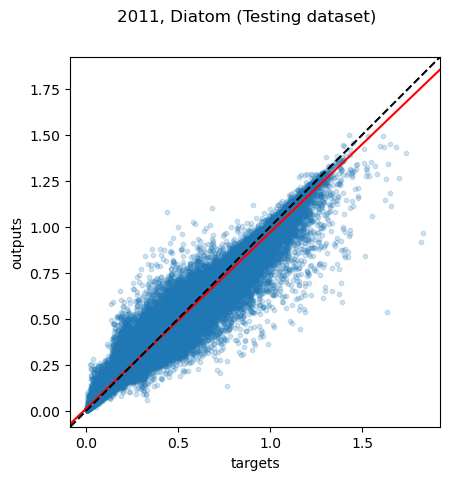

In [19]:
dict_month = {'jan': '01',
         'feb': '02',
         'mar': '03',
         'apr': '04',
         'may': '05',
         'jun': '06',
         'jul': '07',
         'aug': '08',
         'sep': '09',
         'oct': '10',
         'nov': '11',
         'dec': '12'}

path = os.listdir('/results2/SalishSea/nowcast-green.202111/')

# Open the mesh mask
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
mask = mesh.tmask.to_numpy()

year = 2011

year_str = str(year)[2:4]

folders = [x for x in path if ((x[2:5]=='mar' or x[2:5]=='apr' or (x[2:5]=='feb' and x[0:2] > '13')) and (x[5:7]==year_str))]
indx_dates=(np.argsort(pd.to_datetime(folders, format="%d%b%y")))
folders = [folders[i] for i in indx_dates]

drivers_all = np.array([[],[],[],[],[],[],[],[]])
diat_all = np.array([])

print ('Gathering days for year ' + str(year))

for i in tqdm(range(1, len(folders))):

    temp_i1, temp_i2, saline_i1, saline_i2, diat_i, flag_i = datasets_preparation(folders[i])
    temp_i1_y, temp_i2_y, saline_i1_y, saline_i2_y = datasets_preparation_y(folders[i-1])

    drivers = np.stack([np.ravel(temp_i1), np.ravel(temp_i2), 
        np.ravel(saline_i1), np.ravel(saline_i2), np.ravel(temp_i1_y), 
        np.ravel(temp_i2_y), np.ravel(saline_i1_y), np.ravel(saline_i2_y)])  
      
    indx = np.where(~np.isnan(drivers).any(axis=0))
    drivers = drivers[:,indx[0]]
    drivers_all = np.concatenate((drivers_all,drivers),axis=1)

    diat = np.ravel(diat_i)
    diat = diat[indx[0]]
    diat_all = np.concatenate((diat_all,diat))

    sleep(0.1)

print ('Done gathering, building the prediction model')
print ('\n')

r, rms, m, regr = regressor(drivers_all, diat_all, 'Diatom')


## Other Years

  0%|          | 0/17 [00:00<?, ?it/s]

Gathering days for year 2007


100%|██████████| 75/75 [04:07<00:00,  3.31s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.484
The correlation coefficient is: 0.533
 The mean square error is: 0.02251


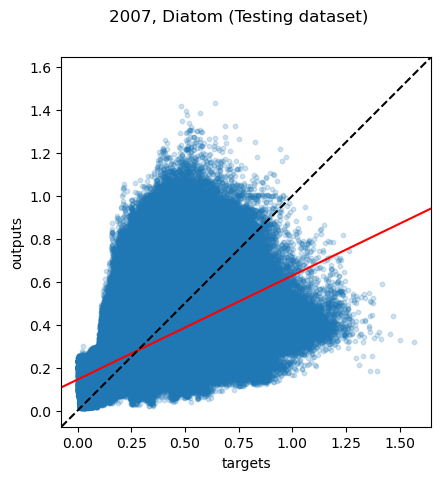

  6%|▌         | 1/17 [04:16<1:08:25, 256.60s/it]

Gathering days for year 2008


100%|██████████| 76/76 [04:16<00:00,  3.38s/it]


The amount of data points is 3532404
The slope of the best fitting line is  0.609
The correlation coefficient is: 0.602
 The mean square error is: 0.01833


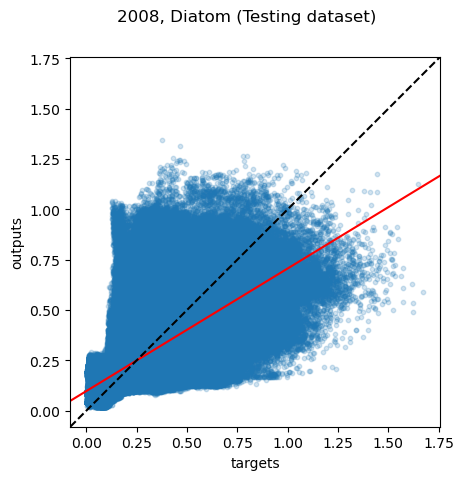

 12%|█▏        | 2/17 [08:42<1:05:27, 261.83s/it]

Gathering days for year 2009


100%|██████████| 75/75 [04:14<00:00,  3.40s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.55
The correlation coefficient is: 0.706
 The mean square error is: 0.02296


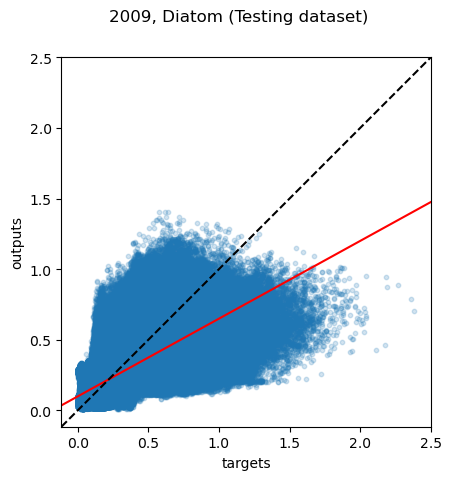

 18%|█▊        | 3/17 [13:05<1:01:18, 262.76s/it]

Gathering days for year 2010


100%|██████████| 75/75 [04:26<00:00,  3.55s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.47
The correlation coefficient is: 0.5
 The mean square error is: 0.0208


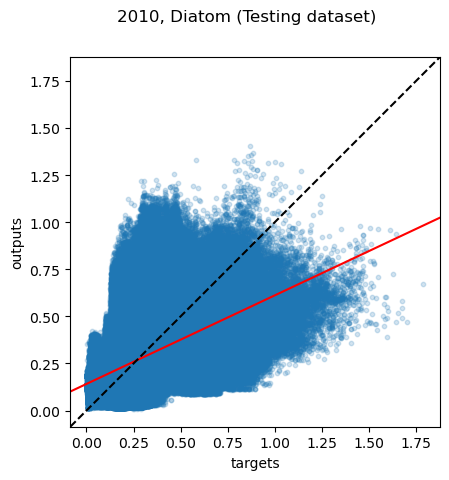

 24%|██▎       | 4/17 [17:40<57:55, 267.37s/it]  

Gathering days for year 2011


100%|██████████| 75/75 [04:18<00:00,  3.45s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.978
The correlation coefficient is: 0.995
 The mean square error is: 0.00025


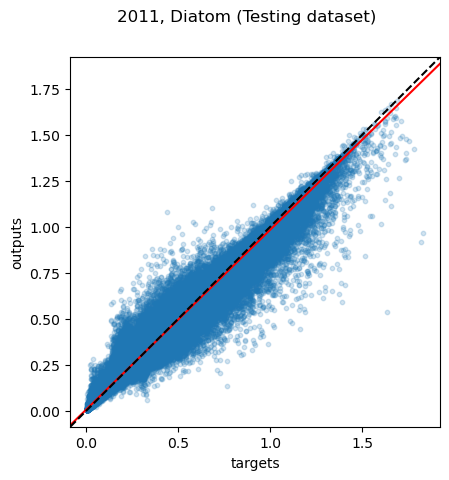

 29%|██▉       | 5/17 [22:10<53:39, 268.30s/it]

Gathering days for year 2012


100%|██████████| 76/76 [04:31<00:00,  3.57s/it]


The amount of data points is 3532404
The slope of the best fitting line is  0.613
The correlation coefficient is: 0.661
 The mean square error is: 0.01605


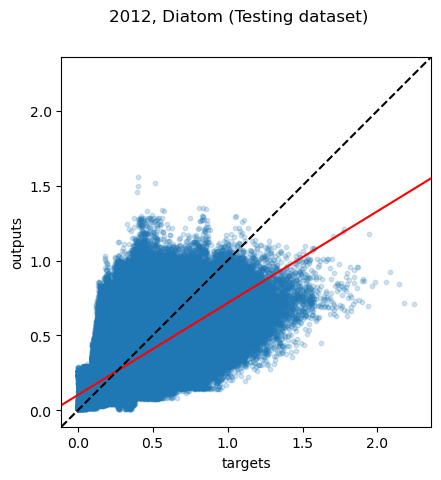

 35%|███▌      | 6/17 [26:51<49:58, 272.59s/it]

Gathering days for year 2013


100%|██████████| 75/75 [04:28<00:00,  3.58s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.377
The correlation coefficient is: 0.458
 The mean square error is: 0.02975


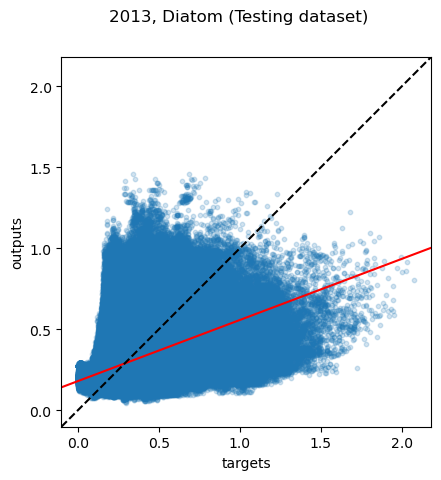

 41%|████      | 7/17 [31:28<45:40, 274.07s/it]

Gathering days for year 2014


100%|██████████| 75/75 [04:26<00:00,  3.56s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.416
The correlation coefficient is: 0.41
 The mean square error is: 0.02563


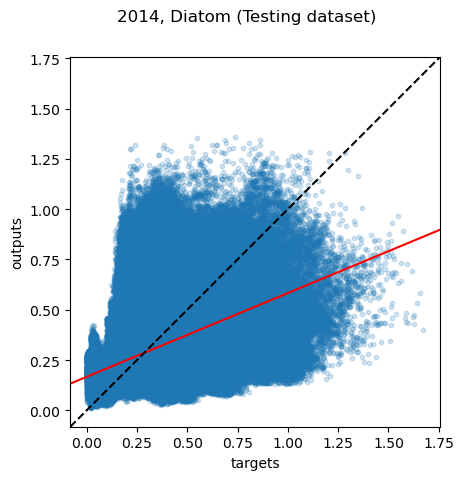

 47%|████▋     | 8/17 [36:03<41:10, 274.52s/it]

Gathering days for year 2015


100%|██████████| 75/75 [04:24<00:00,  3.53s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.17
The correlation coefficient is: 0.193
 The mean square error is: 0.03636


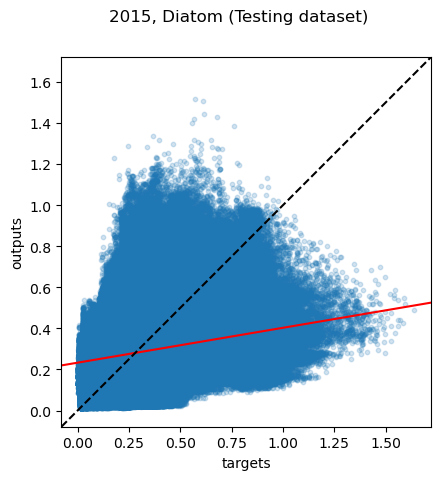

 53%|█████▎    | 9/17 [40:36<36:32, 274.02s/it]

Gathering days for year 2016


100%|██████████| 76/76 [04:36<00:00,  3.64s/it]


The amount of data points is 3532404
The slope of the best fitting line is  0.202
The correlation coefficient is: 0.226
 The mean square error is: 0.0415


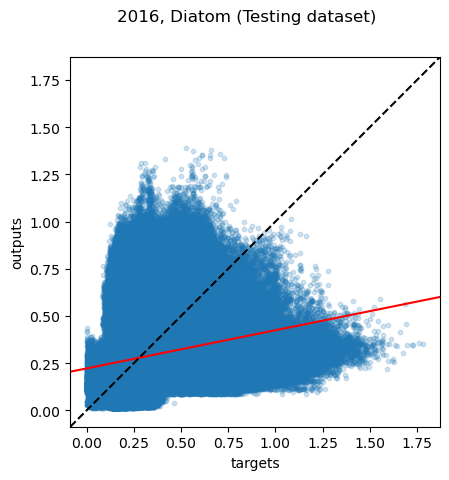

 59%|█████▉    | 10/17 [45:21<32:21, 277.34s/it]

Gathering days for year 2017


100%|██████████| 75/75 [04:27<00:00,  3.57s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.561
The correlation coefficient is: 0.515
 The mean square error is: 0.01949


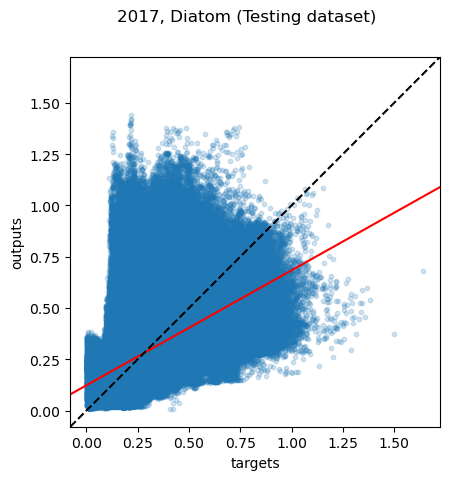

 65%|██████▍   | 11/17 [49:58<27:42, 277.14s/it]

Gathering days for year 2018


100%|██████████| 75/75 [04:27<00:00,  3.57s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.322
The correlation coefficient is: 0.35
 The mean square error is: 0.03158


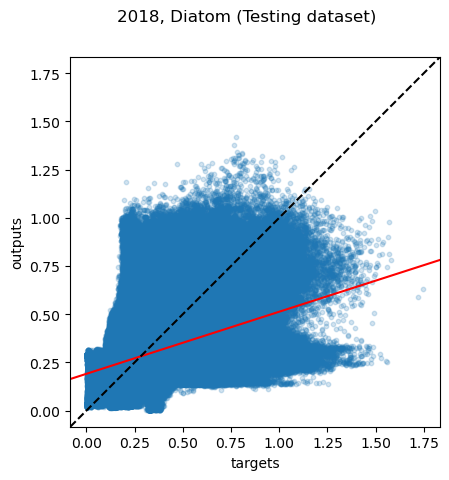

 71%|███████   | 12/17 [54:34<23:04, 276.96s/it]

Gathering days for year 2019


100%|██████████| 75/75 [04:29<00:00,  3.59s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.266
The correlation coefficient is: 0.322
 The mean square error is: 0.03809


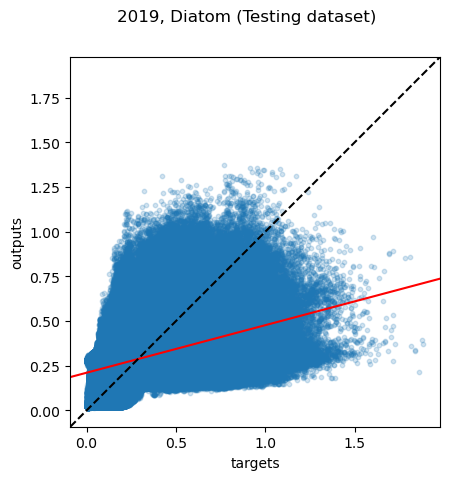

 76%|███████▋  | 13/17 [59:13<18:29, 277.34s/it]

Gathering days for year 2020


100%|██████████| 76/76 [04:31<00:00,  3.57s/it]


The amount of data points is 3532404
The slope of the best fitting line is  0.208
The correlation coefficient is: 0.276
 The mean square error is: 0.05297


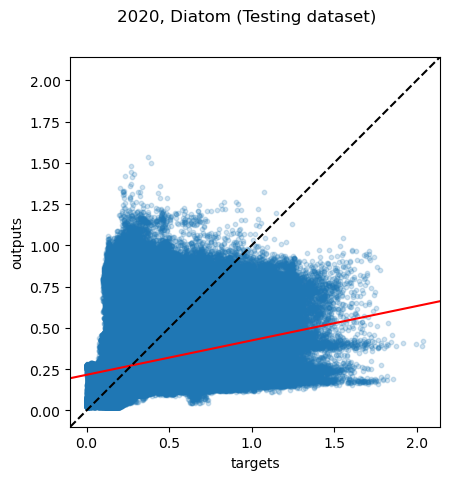

 82%|████████▏ | 14/17 [1:03:53<13:54, 278.17s/it]

Gathering days for year 2021


100%|██████████| 75/75 [04:29<00:00,  3.59s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.367
The correlation coefficient is: 0.438
 The mean square error is: 0.03332


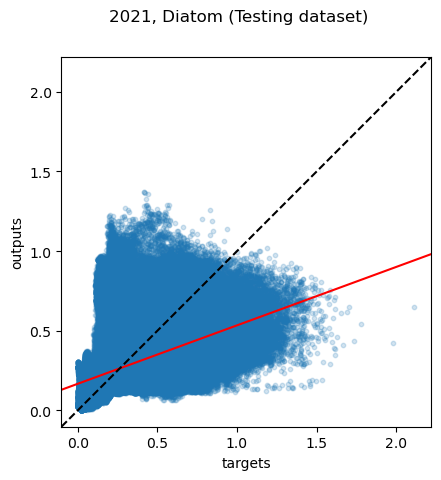

 88%|████████▊ | 15/17 [1:08:30<09:16, 278.07s/it]

Gathering days for year 2022


100%|██████████| 75/75 [04:28<00:00,  3.58s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.522
The correlation coefficient is: 0.543
 The mean square error is: 0.01921


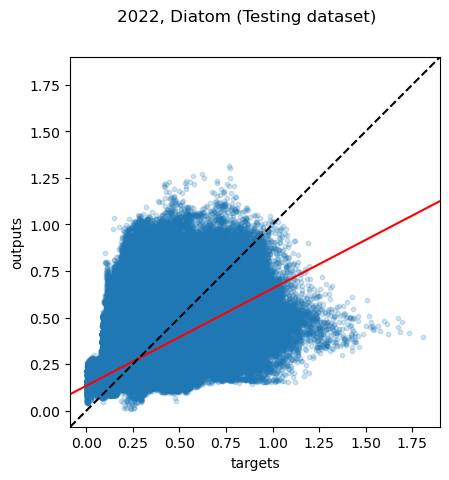

 94%|█████████▍| 16/17 [1:13:08<04:37, 277.87s/it]

Gathering days for year 2023


100%|██████████| 75/75 [04:35<00:00,  3.67s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.219
The correlation coefficient is: 0.284
 The mean square error is: 0.03101


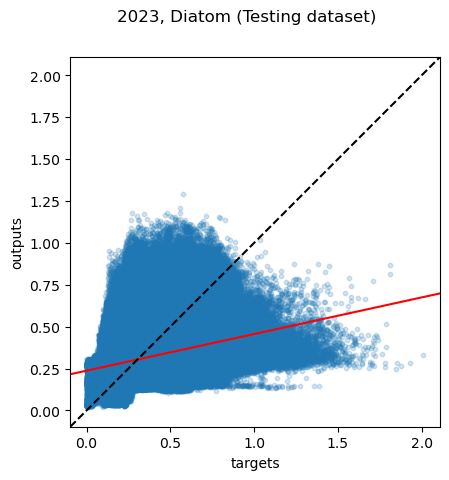

100%|██████████| 17/17 [1:17:52<00:00, 274.87s/it]


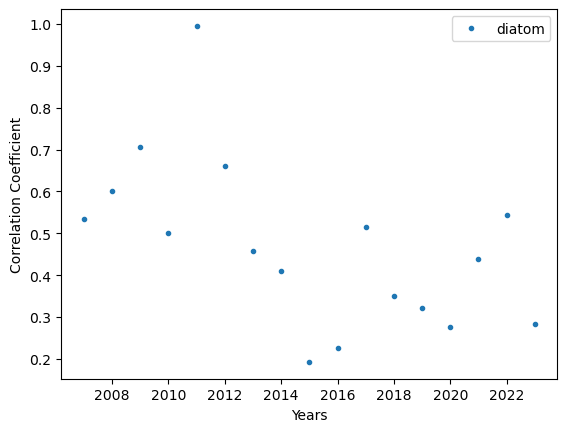

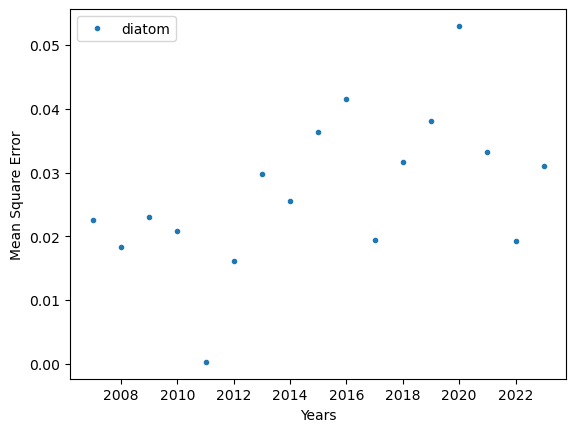

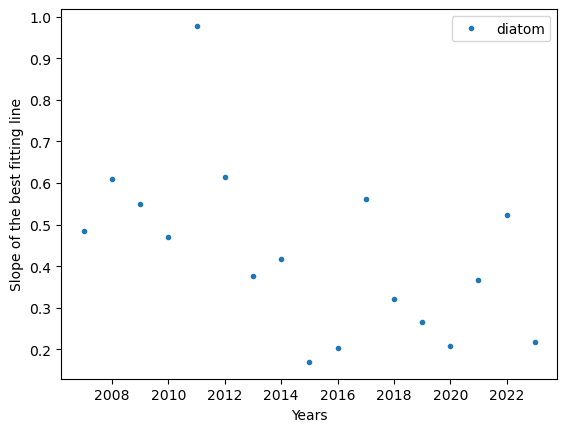

In [20]:
years = range (2007,2024)

r_all = []
rms_all = []
slope_all = []

for year in tqdm(range(2007,2024)):

    year_str = str(year)[2:4]

    folders = [x for x in path if ((x[2:5]=='mar' or x[2:5]=='apr' or (x[2:5]=='feb' and x[0:2] > '13')) and (x[5:7]==year_str))]
    indx_dates=(np.argsort(pd.to_datetime(folders, format="%d%b%y")))
    folders = [folders[i] for i in indx_dates]

    drivers_all = np.array([[],[],[],[],[],[],[],[]])
    diat_all = np.array([])

    print ('Gathering days for year ' + str(year))

    for i in tqdm(range(1, len(folders)), position=0, leave=True):

        temp_i1, temp_i2, saline_i1, saline_i2, diat_i, flag_i = datasets_preparation(folders[i])
        temp_i1_y, temp_i2_y, saline_i1_y, saline_i2_y = datasets_preparation_y(folders[i-1])
        
        drivers = np.stack([np.ravel(temp_i1), np.ravel(temp_i2), np.ravel(saline_i1), 
            np.ravel(saline_i2), np.ravel(temp_i1_y), np.ravel(temp_i2_y), 
            np.ravel(saline_i1_y), np.ravel(saline_i2_y)])
        indx = np.where(~np.isnan(drivers).any(axis=0))
        drivers = drivers[:,indx[0]]
        drivers_all = np.concatenate((drivers_all,drivers),axis=1)

        diat = np.ravel(diat_i)
        diat = diat[indx[0]]
        diat_all = np.concatenate((diat_all,diat))

        sleep(0.1)

    r, rms, m = regressor2(drivers_all, diat_all, 'Diatom')
    r_all.append(r)
    rms_all.append(rms)
    slope_all.append(m)

    sleep(0.1)
    
plotting(np.transpose(r_all), 'Correlation Coefficient')
plotting(np.transpose(rms_all), 'Mean Square Error')
plotting (np.transpose(slope_all), 'Slope of the best fitting line')
